In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(".."))
import access_br_dwgd as access_br_dwgd
sys.path.append(os.path.abspath("../.."))
from utils.lstmModel import LstmModel
import utils.utils as util
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="../../logs/lstmBrDwgd.log", nome_classe="Lstm BrDwgd")
logger.info("Iniciando script de previsão com LSTM BrDwgd.")

2025-10-26 09:25:26.497963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-26 09:25:27,916 - Lstm BrDwgd - INFO - Iniciando script de previsão com LSTM BrDwgd.


1961-01-01    31.000000
1961-01-02    31.400000
1961-01-03    30.200001
1961-01-04    29.500000
1961-01-05    28.700001
                ...    
2024-03-16     0.000000
2024-03-17     0.000000
2024-03-18     0.000000
2024-03-19     0.000000
2024-03-20     0.000000
Freq: D, Name: 83790, Length: 23090, dtype: float32
1961-01-01    22.600000
1961-01-02    24.400000
1961-01-03    24.500000
1961-01-04    22.799999
1961-01-05    24.200001
                ...    
2024-03-16     0.000000
2024-03-17     0.000000
2024-03-18     0.000000
2024-03-19     0.000000
2024-03-20     0.000000
Freq: D, Name: 83790, Length: 23090, dtype: float32
1961-01-01    86.75
1961-01-02    81.50
1961-01-03    79.00
1961-01-04    78.25
1961-01-05    86.25
              ...  
2024-03-16     0.00
2024-03-17     0.00
2024-03-18     0.00
2024-03-19     0.00
2024-03-20     0.00
Freq: D, Name: 83790, Length: 23090, dtype: float32


2025-10-26 09:26:40,010 - Lstm BrDwgd - INFO - Dados carregados com sucesso. Total de 701 registros.


1961-01-01    12.755219
1961-01-02    11.793065
1961-01-03    17.538496
1961-01-04    15.776907
1961-01-05    12.417495
                ...    
2024-03-16     0.000000
2024-03-17     0.000000
2024-03-18     0.000000
2024-03-19     0.000000
2024-03-20     0.000000
Freq: D, Name: 83790, Length: 23090, dtype: float32
1961-01-01    0.0
1961-01-02    0.0
1961-01-03    0.6
1961-01-04    0.0
1961-01-05    0.0
             ... 
2024-03-16    0.0
2024-03-17    0.0
2024-03-18    0.0
2024-03-19    0.0
2024-03-20    0.0
Freq: D, Name: 83790, Length: 23090, dtype: float32
            chuva  Tmax  Tmin   RH   Rs   u2
1991-01-01    0.0  31.4  19.9  0.0  0.0  0.0


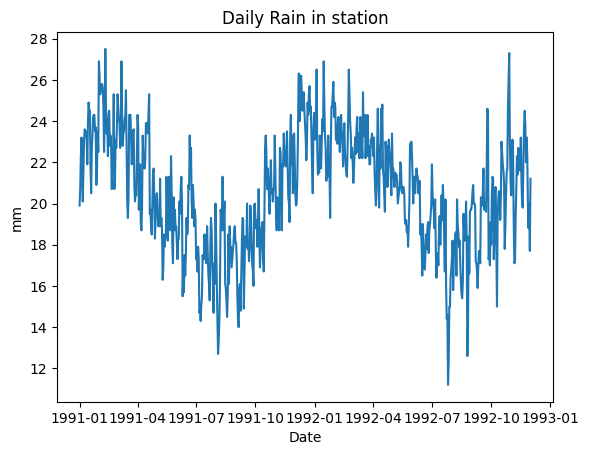

In [ ]:
#Precipitation (pr, mm);
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()


logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
print(timeseries.head(1))
datas = timeseries.index 
plt.plot(timeseries['Tmin'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

plt.plot(timeseries['Tmax'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

plt.plot(timeseries['RH'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

plt.plot(timeseries['Rs'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

plt.plot(timeseries['u2'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

In [ ]:
lookback = 1
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = util.create_sequence(timeseries, lookback)
train_size = int(len(timeseries) * 0.75)
print(X[1][0])
print(y[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = datas[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")


In [ ]:
n_epochs = 100
batch_size = 32
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  
model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=n_epochs,
                 batch_size = batch_size,
                 verbose=2)

In [ ]:
logger.info(f"Iniciando treinamento do modelo por {n_epochs} épocas com batch_size de {batch_size}.")
best_loss = float("inf")
best_state = None
# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
logger.info("Realizando previsões no conjunto de teste.")
pred = model.predict(X_test)
#pred_rescaled = scaler.inverse_transform(pred)
#real_rescaled = scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

y_pred_np, y_test_np = None, None

In [ ]:
logger.info("Gerando gráfico de previsão final.")
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logger.info("Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.")